### Import trained model
Run `nvidia-smi -l 1` to check the memory being used by what.
You will need to restart the kernel if the program is crashing as jupyter stays allive and keeps the data in the memory.

In [2]:
import pickle
import keras
import librosa
import librosa.display
import numpy as np
from sklearn import metrics
import tensorflow as tf
from keras.models import load_model

#sound_model_file = "sound_model.pkl"
label_encoder_file = "labelencoder.pkl"


model = None

model = load_model('sound_category_model.h5')

#with open(sound_model_file, 'rb') as file:
#    model = pickle.load(file)

with open(label_encoder_file, 'rb') as file:
    le = pickle.load(file)

%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
#%store -r model 
#%store -r le
%store -r X
%store -r y

In [3]:
usl = "../resources/UrbanSound8K/"

In [4]:

num_rows = 40
num_columns = 174
num_channels = 1

max_pad_len = 174

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

6935/6935 [==============================] - 1s 164us/step
Training Accuracy:  0.9936553835868835
1734/1734 [==============================] - 0s 66us/step
Testing Accuracy:  0.9486736059188843


In [5]:
def prediction(file_name, print_data = False):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector)
    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    if print_data:
        print("The predicted class is:", predicted_class[0], '\n') 
        
        for i in range(len(predicted_proba)): 
            category = le.inverse_transform(np.array([i]))
            print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )
    return (predicted_class[0], format(predicted_proba[predicted_vector[0]] * 100, '.32f'))

In [6]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name, e)
        return None 
     
    return mfccs

In [7]:
# Class: Air Conditioner

filename = usl + 'audio/fold5/100852-0-0-0.wav' 
prediction(filename, True) 

The predicted class is: air_conditioner 

air_conditioner 		 :  0.99971801042556762695312500000000
car_horn 		 :  0.00000000003034992743233821954618
children_playing 		 :  0.00010197135998168960213661193848
dog_bark 		 :  0.00000000347922135546241406700574
drilling 		 :  0.00000009600837103107551229186356
engine_idling 		 :  0.00017687170475255697965621948242
fire_alarm 		 :  0.00000000000000000000000000113727
jackhammer 		 :  0.00000048088458015627111308276653
siren 		 :  0.00000000632121599508650433563162
street_music 		 :  0.00000246614376919751521199941635


('air_conditioner', '99.97180104255676269531250000000000')

In [8]:
predictions = model.predict(x_test)
y_pred = (predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

### Checking data from testing for more info

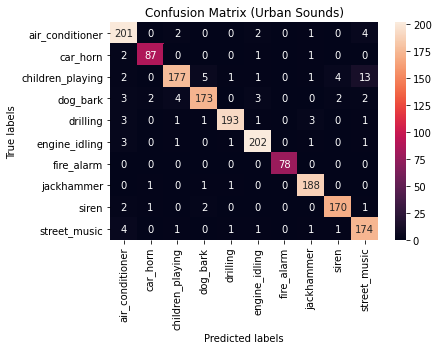

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

label_names = le.classes_

plt.figure()
ax= plt.subplot(111)
sns.heatmap(matrix, annot=True, ax = ax, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (Urban Sounds)')
ax.xaxis.set_ticklabels(label_names, rotation='vertical');
ax.yaxis.set_ticklabels(label_names, rotation='horizontal');

plt.show()

### Test with sounds from odas

In [12]:
from os import listdir
from os.path import isfile, join

odas_clips = "/home/sekwah/Music/"

sound_files = [f for f in listdir(odas_clips) if isfile(join(odas_clips, f))]

#print(sound_files)

for file in sound_files:
    try:
        predict = prediction(join(odas_clips, file), False)
        print("{} {}% {}".format(predict[0], predict[1], file))
    except:
        print("Error reading file: " + join(odas_clips, file))

Error encountered while parsing file:  /home/sekwah/Music/ODAS_1_2020-4-23_19-20-44-24_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_1_2020-4-23_19-20-44-24_sp.wav
dog_bark 91.87302589416503906250000000000000% ODAS_1_2020-4-23_19-20-44-24_11_pf.wav
dog_bark 80.13550639152526855468750000000000% ODAS_1_2020-4-23_19-20-44-24_12_pf.wav
dog_bark 96.68527841567993164062500000000000% ODAS_1_2020-4-23_19-20-44-24_13_pf.wav
children_playing 48.53754639625549316406250000000000% ODAS_1_2020-4-23_19-20-44-24_3_pf.wav
dog_bark 100.00000000000000000000000000000000% ODAS_9_2020-4-24_19-38-54-431_pf.wav
drilling 64.50338959693908691406250000000000% ODAS_1_2020-4-23_19-20-44-24_8_pf.wav
siren 100.00000000000000000000000000000000% 2secsiren.wav
drilling 62.25526928901672363281250000000000% ODAS_1_2020-4-23_19-20-44-24_2_pf.wav
car_horn 70.44110894203186035156250000000000% ODAS_1_2020-4-23_19-20-44-24_10_pf.wav
siren 99.99096393585205078125000000000000% 1secsiren.